In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
import re
from collections import defaultdict
from matplotlib import rcParams
import scienceplots

In [2]:
def parse_filename(filename):
    """
    Parses the filename to extract algorithm, hyperparameters, and seed.
    
    Args:
        filename (str): The name of the file.
    
    Returns:
        tuple: (algorithm (str), hyperparams (dict), seed (int), rescale (bool))
    """
    # Remove the file extension
    name = filename.split('.csv')[0]
    
    # Split the name by underscores
    parts = name.split('_')
    
    # The first part is the algorithm
    algorithm = parts[0]
    
    hyperparams = {}
    seed = None

    # Regular expression to match key-value pairs (e.g., lr0.1, bs128, rf10)
    pattern = re.compile(r'([a-zA-Z]+)([\d.]+)')
    hyperparams['rescale'] = False
    for part in parts[1:]:
        # Check if the part is 'rescale'
  
        if part == 'rescale':
            hyperparams['rescale'] = True
        # Check if the part represents a seed (e.g., s1)
        elif part.startswith('s') and part[1:].isdigit():
            seed = int(part[1:])
        # Check for key-value pairs (e.g., lr0.1, bs128)
        else:
            match = pattern.match(part)
            if match:
                key, value = match.groups()
                hyperparams[key] = value
    if filename.startswith('sgd'):
        if ('lr1.6' in filename and 'bs2048' in filename) or ('lr0.16' in filename and 'bs2048' in filename):
            hyperparams['rescale'] = True
        else:
            hyperparams['rescale'] = False

        
    
    return algorithm, hyperparams, seed


def extract_numeric_from_tensor_string(s):
    """
    Extracts the numeric value from a string formatted like "tensor(1.1200, device='cuda:0')"
    or returns the value directly if it's already a numeric type.
    
    Args:
        s (str or float or int): The input value from the 'val_acc' column.
    
    Returns:
        float: The extracted numeric value, or NaN if extraction fails.
    """
    # If the input is already a numeric type, return it as a float
    if isinstance(s, (int, float)):
        return float(s)
    
    # If the input is a string, attempt to extract the numeric value
    elif isinstance(s, str):
        # Define a regex pattern to capture the number inside 'tensor(...)'
        pattern = r'tensor\(([\d.]+),'
        match = re.search(pattern, s)
        if match:
            try:
                return float(match.group(1))
            except ValueError:
                # In case the captured group is not a valid float
                return float('nan')
        else:
            # Attempt to convert the string directly to float if it doesn't match the pattern
            try:
                return float(s)
            except ValueError:
                return float('nan')
    
    # For any other data types, return NaN
    else:
        return float('nan')



def validate_val_acc(algorithm, hyperparam_str, summary_df):
    """
    Validates that val_acc_mean values are within the expected range (0-100).
    Prints anomalies if found.

    Args:
        algorithm (str): The algorithm name.
        hyperparam_str (str): The hyperparameter string.
        summary_df (pd.DataFrame): The summary DataFrame with aggregated metrics.
        dataset_name (str): Name of the dataset for logging purposes.

    Returns:
        None
    """
    # Check if 'val_acc_mean' exists
    if 'val_acc_mean' not in summary_df.columns:
        print(f"'val_acc_mean' column missing for algorithm '{algorithm}' with hyperparameters '{hyperparam_str}' in {dataset_name}.")
        return

    # Identify rows where 'val_acc_mean' is outside [0, 100]
    invalid_vals = summary_df[
        (summary_df['val_acc_mean'] < 0) | (summary_df['val_acc_mean'] > 100)
    ]


    if not invalid_vals.empty:
        print(f"'val_acc_mean' values outside [0, 100] for algorithm '{algorithm}' with hyperparameters '{hyperparam_str}'")


def process_directory(directory):
    """
    Processes the given directory to compute average validation accuracies.

    Args:
        directory (str): Path to the directory containing CSV files.

    Returns:
        dict: average_acc_dict[algorithm][hyperparam_str] = pd.Series of averaged val_acc
        Additionally, prints out any hyperparam configs missing seeds 1..5 and non-numeric val_acc entries.
    """
    # We'll store data as data_groups[algorithm][hyperparam_str][seed] = df
    data_groups = defaultdict(lambda: defaultdict(dict))

    # ---------------------------
    # Read all CSVs
    # ---------------------------
    imgnet_columns = [ 
    'epoch', 'train_loss', 'train_acc', 'val_loss', 'val_acc1', 'val_acc5',
    'learning_rate', 'batch_size', 'epoch_time', 'eval_time', 
    'abs_time', 'memory_allocated_mb', 'memory_reserved_mb', 'grad_diversity'
    ]


    for filename in os.listdir(directory):
        if not filename.endswith('.csv'):
            continue
        # Parse filename to extract components
        algorithm, hyperparams, seed= parse_filename(filename)
        # print(f"Processing '{filename}': {algorithm}, {hyperparams}, {seed}")

        # Build a consistent hyperparam_str
        hyperparam_items = hyperparams.items()
        hyperparam_str = '_'.join([f"{k}{v}" for k, v in hyperparam_items])

        # If there's no seed in the file name, skip or handle differently
        if seed is None:
            print(f"Warning: No seed found in filename '{filename}'. Skipping.")
            continue

        file_path = os.path.join(directory, filename)
        # Read the first row to check for a header
        with open(file_path, 'r') as file:
            first_line = file.readline().strip().split(',')
            
        # Check if the first line matches the expected header
        if 'epoch' not in first_line:
            df = pd.read_csv(file_path, header=None, names=imgnet_columns)
        else:
            df = pd.read_csv(file_path)
        


        # print(f"{filename} - val_acc dtype: {df['val_acc'].dtype}")

        # 2.1) SHIFT + REWRITE "epoch" if out of [0..199] or [1..200], etc.
        if "epoch" in df.columns:
            epoch_min, epoch_max = df["epoch"].min(), df["epoch"].max()
        else:
            epoch_min = epoch_max = -1
        if 'val_acc1' in df.columns:
            df.rename(columns={'val_acc1': 'val_acc'}, inplace=True)

        if 'sgd_' in filename:
            if 'grad_diversity' in df.columns:
                df.drop(columns=['grad_diversity'], inplace=True)


        last_col = df.iloc[:, -1]
        all_nan_last_col = last_col.isna().all()

        # Decide if epoch is invalid
        not_valid_epoch = not ((epoch_min == 0) or (epoch_min == 1))

        if all_nan_last_col and not_valid_epoch:
            df = df.shift(periods=1, axis=1)
            df["epoch"] = range(1, len(df) + 1)
            print(f"Shifted and rewrote 'epoch' column for '{filename}'")
            # print(df.head())
        
        if 'abs_time' not in df.columns:
            print(f"Warning: 'abs_time' column missing in '{filename}'. Skipping.")



        df['val_acc'] = df['val_acc'].apply(extract_numeric_from_tensor_string)

        # if max(df['val_loss']) > 10:
        #     print(f"Warning: 'val_loss' values in '{filename}' are too high. Skipping.")
        #     print(df['val_loss'])
            

        non_numeric = pd.to_numeric(df['val_acc'], errors='coerce').isna()
        # if non_numeric.any():
        #     epochs_with_non_numeric = df.loc[non_numeric, 'epoch'].tolist()
        #     print(f"Warning: Non-numeric 'val_acc' entries in '{filename}' at epochs {epochs_with_non_numeric}. These will be set to NaN.")
        # Identify non-numeric 'val_acc' entries
        non_numeric_val_acc = df[df['val_acc'].isna()]
        # if not non_numeric_val_acc.empty:
        #     print(f"[WARNING] Non-numeric 'val_acc' entries found in '{filename}':")
        #     print(non_numeric_val_acc)

        # Optionally, handle missing 'val_acc' values
        # Example: Drop rows where 'val_acc' is NaN
        # df.dropna(subset=['val_acc'], inplace=True)

        # Check for duplicate 'epoch' values
        duplicate_epochs = df['epoch'][df['epoch'].duplicated()].unique()
        if len(duplicate_epochs) > 0:
            # print(f"[WARNING] Duplicate 'epoch' values found in '{filename}': {duplicate_epochs}")
            # Optionally, keep the first occurrence and drop duplicates
            df = df.drop_duplicates(subset=['epoch'], keep='first')

        # OPTIONAL: Sort by epoch so the final index is in ascending order
        df.sort_values("epoch", inplace=True)

        # 2.2) Store the DataFrame in our dictionary
        data_groups[algorithm][hyperparam_str][seed] = df

        # except Exception as e:
        #     print(f"Error reading '{filename}': {e}")

    # Compute the average val_acc across seeds
    # ---------------------------
    average_acc_dict = defaultdict(dict)

    for algorithm, hyperparams_dict in data_groups.items():
        for hyperparam_str, seeds_dict in hyperparams_dict.items():
            # Check for missing seeds (assuming seeds 1 to 5)
            expected_seeds = set(range(1, 6))
            present_seeds = set(seeds_dict.keys())
            missing_seeds = expected_seeds - present_seeds
            if missing_seeds:
                print(f"Warning: Missing seeds {sorted(missing_seeds)} for algorithm '{algorithm}' with hyperparameters '{hyperparam_str}'.")

            # Collect all dataframes for available seeds
            dfs = []
            for seed in sorted(seeds_dict.keys()):
                df = seeds_dict[seed].copy()
                df['seed'] = seed
                dfs.append(df)

            # if not dfs:
            #     print(f"Warning: No data available for algorithm '{algorithm}' with hyperparameters '{hyperparam_str}'. Skipping.")
            #     continue

            # Concatenate all dataframes
            combined_df = pd.concat(dfs, ignore_index=True)

            # Group by epoch
            grouped = combined_df.groupby('epoch')

            # Compute mean and SEM for val_acc and val_loss
            summary_df = grouped.agg(
                val_acc_mean=('val_acc', 'mean'),
                val_acc_sem=('val_acc', 'sem'),
                val_loss_mean=('val_loss', 'mean'),
                val_loss_sem=('val_loss', 'sem'),           
                abs_time_mean=('abs_time', 'mean'),  # Average absolute time
                abs_time_sem=('abs_time', 'sem'),    # Standard error for absolute time
                epoch_time_mean=('epoch_time', 'mean'),
                epoch_time_sem=('epoch_time', 'sem'),

            ).reset_index()
            validate_val_acc(algorithm, hyperparam_str, summary_df)
            average_acc_dict[algorithm][hyperparam_str] = summary_df

    return average_acc_dict


In [3]:
def split_data_by_rescale(average_acc_dict):
    """
    Splits the data into two groups based on 'rescaleTrue' and 'rescaleFalse'.
    Ensures that all entries with the 'sgd' algorithm are included in both groups.

    Args:
        average_acc_dict (dict): The dictionary containing average accuracies.
    
    Returns:
        dict: Two dictionaries, one for each group.
    """
    rescale_true = defaultdict(dict)
    rescale_false = defaultdict(dict)

    for algorithm, hyperparams_dict in average_acc_dict.items():
        for hyperparam_str, summary_df in hyperparams_dict.items():
            # Check the 'rescale' value in the hyperparameters
            if algorithm == 'sgd' and ('bs256' in hyperparam_str or 'bs128' in hyperparam_str): 
                rescale_true[algorithm][hyperparam_str] = summary_df
                rescale_false[algorithm][hyperparam_str] = summary_df
            elif 'rescaleTrue' in hyperparam_str:
                rescale_true[algorithm][hyperparam_str] = summary_df
            elif 'rescaleFalse' in hyperparam_str:
                rescale_false[algorithm][hyperparam_str] = summary_df

    return rescale_true, rescale_false

In [4]:
def split_data_by_resize_freq(data_dict):
    """
    Splits the data further by 'resize_freq' (denoted as 'rf' in the hyperparameter string).

    Args:
        data_dict (dict): The dictionary containing rescale-split data.
    
    Returns:
        dict: Nested dictionaries with data grouped by resize_freq.
    """
    # Dictionary to hold data split by resize_freq
    resize_freq_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

    for algorithm, hyperparams_dict in data_dict.items():
        for hyperparam_str, summary_df in hyperparams_dict.items():
            # Extract the resize_freq (rf) value from the hyperparam_str
            rf_match = re.search(r'rf(\d+)', hyperparam_str)
            if rf_match:
                resize_freq = int(rf_match.group(1))
                if resize_freq <= 10:
                    continue
                    
            else:
                # If 'rf' is not found, assign a default value (e.g., -1 or 'None')
                resize_freq = -1
            
            # Organize data by algorithm, resize_freq, and hyperparam_str
            resize_freq_dict[resize_freq][algorithm][hyperparam_str] = summary_df

    return resize_freq_dict

In [5]:
def plot_val_acc_and_loss_with_baseline(dataset, rescale_dict, rescale_status, filter_hyperparams=None, x_axis='epoch', plot_dir = '../plots',save=False):
    """
    Plots validation accuracy and loss for each (rescale_status, rf) pair,
    ensuring 'SGD' algorithm is plotted first.

    Args:
        rescale_dict (dict): The dictionary split by `resize_freq` (rf).
        rescale_status (str): Either 'rescaleTrue' or 'rescaleFalse' for labeling purposes.
        filter_hyperparams (function, optional): A filter function for hyperparameter strings.
        save (bool, optional): Whether to save the plots as PDF.

    Returns:
        None
    """
    dataset_map = {'cifar10': 'CIFAR-10', 'cifar100': 'CIFAR-100', 'imagenet': 'Tiny-ImageNet'}
    # Define styling elements
    CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']
    # method_colors = {}
    name_map = {'SGD': 'SGD', 'adabatch': 'AdaBatch', 'divebatch': 'DiveBatch'}
    color_iterator = iter(CB_color_cycle)
    if save:
        plt.style.use(['science','ieee'])
        plt.rcParams['axes.prop_cycle'] = plt.cycler(color=CB_color_cycle)
        plt.rcParams['text.usetex'] = False
        plt.rcParams['font.family'] = 'DejaVu Serif'
        plt.rcParams['font.serif'] = ['Computer Modern Roman']

    # Iterate over resize_freq (rf) values
    for rf, algorithm_dict in rescale_dict.items():
        if rf <= 10:
            continue

        plt.figure(figsize=(3.3, 2.6))
        # Validation Accuracy Plot
        color_iterator = iter(CB_color_cycle)
        method_colors = {}
        handles, labels = [], []

        # Plot SGD first
        for algorithm, hyperparams_dict in rescale_dict.get(-1, {}).items():  # Baseline SGD entries
            if algorithm.lower() == 'sgd':
                for hyperparam_str, summary_df in hyperparams_dict.items():
                    if filter_hyperparams and not filter_hyperparams(hyperparam_str):
                        continue
                    unique_key = f"SGD_{hyperparam_str}"
                    if unique_key not in method_colors:
                        method_colors[unique_key] = next(color_iterator, CB_color_cycle[0])
                    if not save:
                        label = f"SGD ({hyperparam_str})"
                    else:
                        batch = hyperparam_str.split('bs')[1].split('_')[0]
                        label = f"SGD ({batch})"
                    color = method_colors[unique_key]
                    zorder =  2

                    y_values = summary_df['val_acc_mean']
                    y_err = summary_df['val_acc_sem']

                    if x_axis == 'epoch':
                        x_values = summary_df['epoch']
                        line, = plt.plot(
                            x_values, 
                            y_values,
                            linestyle=':', 
                            label=label,
                            color=color,
                            zorder=zorder
                        )
                    elif x_axis == 'abs_time':
                        x_values = summary_df['abs_time_mean']
                        line, = plt.plot(
                            x_values, 
                            y_values,
                            linestyle=':', 
                            label=label,
                            color=color,
                            zorder=zorder
                        )
                    # Add shaded error region
                    plt.fill_between(x_values, y_values - y_err, y_values + y_err, color=color, alpha=0.2)
                    handles.append(line)
                    labels.append(label)

        # Plot other algorithms
        for algorithm, hyperparams_dict in algorithm_dict.items():
            if algorithm.lower() == 'sgd':
                continue  # Skip SGD since it's already plotted

            for hyperparam_str, summary_df in hyperparams_dict.items():
                if filter_hyperparams and not filter_hyperparams(hyperparam_str):
                    continue

                unique_key = f"{algorithm}_{hyperparam_str}"
                if unique_key not in method_colors:
                    method_colors[unique_key] = next(color_iterator, CB_color_cycle[0])
                if not save:
                    label = f"{name_map.get(algorithm, algorithm)} ({hyperparam_str})"
                else:
                    init_bs = hyperparam_str.split('bs')[1].split('_')[0]
                    max_bs = hyperparam_str.split('mbs')[1].split('_')[0]
                    label = f"{name_map.get(algorithm, algorithm)} ({init_bs} - {max_bs})"
                color = method_colors[unique_key]
                linewidth = 1 if 'divebatch' in algorithm else 1
                zorder = 1 if 'divebatch' in algorithm else 2

                y_values = summary_df['val_acc_mean']
                y_err = summary_df['val_acc_sem']
                if x_axis == 'epoch':
                    x_values = summary_df['epoch']
                    line, = plt.plot(
                        x_values,
                        y_values,
                        label=label,
                        color=color,
                        linewidth=linewidth,
                        zorder=zorder
                    )
                elif x_axis == 'abs_time':
                    x_values = summary_df['abs_time_mean']
                    line, = plt.plot(
                        x_values,
                        y_values,
                        label=label,
                        color=color,
                        linewidth=linewidth,
                        zorder=zorder
                    )
                plt.fill_between(x_values, y_values - y_err, y_values + y_err, color=color, alpha=0.2)
                handles.append(line)
                labels.append(label)

        plt.title(dataset_map[dataset],fontsize = 12)
        plt.xlabel(x_axis.capitalize(), fontsize=10)
        plt.ylabel("Validation Accuracy", fontsize=10)
        plt.legend(handles, labels, loc="best", fontsize=9)
        if save:
            plt.grid(linestyle='dotted')
            plt.savefig(f'{plot_dir}/{dataset}_val_acc_{x_axis}_{rescale_status}_rf{rf}.pdf', format='pdf')
            plt.tick_params(axis='both', which='major', labelsize=8)
        else:
            plt.show()
        plt.close()

        plt.figure(figsize=(3.3, 2.6))
        handles, labels = [], []
        method_colors = {}
        # Reset the color map before plotting losses
        color_iterator = iter(CB_color_cycle)  # Reinitialize custom color iterator

        # Plot SGD first
        for algorithm, hyperparams_dict in rescale_dict.get(-1, {}).items():  # Baseline SGD entries
            if algorithm.lower() == 'sgd':
                for hyperparam_str, summary_df in hyperparams_dict.items():
                    if filter_hyperparams and not filter_hyperparams(hyperparam_str):
                        continue
                    unique_key = f"SGD_{hyperparam_str}"
                    if unique_key not in method_colors:
                        method_colors[unique_key] = next(color_iterator, CB_color_cycle[0])
                    if not save:
                        label = f"SGD ({hyperparam_str})"
                    else:
                        batch = hyperparam_str.split('bs')[1].split('_')[0]
                        label = f"SGD ({batch})"
                    zorder = 2
                    color = method_colors[unique_key]
                    y_values = summary_df['val_loss_mean']
                    y_err = summary_df['val_loss_sem']
                    if x_axis == 'epoch':
                        x_values = summary_df['epoch']
                        line, = plt.plot(
                            x_values,
                            y_values,
                            linestyle=':', 
                            label=label,
                            color=color,
                            zorder=zorder
                        )
                    elif x_axis == 'abs_time':
                        x_values = summary_df['abs_time_mean']
                        line, = plt.plot(
                            x_values,
                            y_values,
                            linestyle=':', 
                            label=label,
                            color=color,
                            zorder=zorder
                        )

                    plt.fill_between(x_values, y_values - y_err, y_values + y_err, color=color, alpha=0.2)
                    handles.append(line)
                    labels.append(label)

        # Plot other algorithms
        for algorithm, hyperparams_dict in algorithm_dict.items():
            if algorithm.lower() == 'sgd':
                continue  # Skip SGD since it's already plotted

            for hyperparam_str, summary_df in hyperparams_dict.items():
                if filter_hyperparams and not filter_hyperparams(hyperparam_str):
                    continue

                unique_key = f"{algorithm}_{hyperparam_str}"
                if unique_key not in method_colors:
                    method_colors[unique_key] = next(color_iterator, CB_color_cycle[0])
                linewidth = 1 if 'divebatch' in algorithm else 1
                zorder = 1 if 'divebatch' in algorithm else 2

                if not save:
                    label = f"{name_map.get(algorithm, algorithm)} ({hyperparam_str})"
                else:
                    init_bs = hyperparam_str.split('bs')[1].split('_')[0]
                    max_bs = hyperparam_str.split('mbs')[1].split('_')[0]
                    label = f"{name_map.get(algorithm, algorithm)} ({init_bs} - {max_bs})"
                color = method_colors[unique_key]

                y_values = summary_df['val_loss_mean']
                y_err = summary_df['val_loss_sem']
                if x_axis == 'epoch':
                    x_values = summary_df['epoch']
                    line, = plt.plot(
                        summary_df['epoch'], 
                        summary_df['val_loss_mean'], 
                        label=label,
                        color=color,
                        linewidth=linewidth,
                        zorder=zorder
                    )
                elif x_axis == 'abs_time':
                    x_values = summary_df['abs_time_mean']
                    line, = plt.plot(
                        summary_df['abs_time_mean'], 
                        summary_df['val_loss_mean'], 
                        label=label,
                        color=color,
                        linewidth=linewidth,
                        zorder=zorder
                    )
                plt.fill_between(x_values, y_values - y_err, y_values + y_err, color=color, alpha=0.2)
                handles.append(line)
                labels.append(label)

        plt.title(dataset_map[dataset],fontsize = 12)
        plt.xlabel(x_axis.capitalize(), fontsize=10)
        plt.ylabel("Validation Loss", fontsize=10)
        if dataset == 'cifar10':
            plt.ylim(0, 2)
        elif dataset == 'cifar100' and rescale_status == 'rescaleTrue':
            plt.ylim(0, 10)
        elif dataset == 'cifar100' and rescale_status == 'rescaleFalse':
            plt.ylim(0.5, 5)
        if save:
            plt.grid(linestyle='dotted')
            plt.legend(handles, labels, loc='best', fontsize=9)
            plt.tick_params(axis='both', which='major', labelsize=8)
            plt.savefig(f"{plot_dir}/{dataset}_val_loss_{x_axis}_{rescale_status}_rf{rf}.pdf", format='pdf')
        else:
            plt.show()
        plt.close()

In [6]:
def generate_table_with_time(df, rescale_type):
    """
    Generate a LaTeX table with dataset names not repeated, formatted algorithm names,
    and additional columns for time metrics.

    Args:
        df (pd.DataFrame): DataFrame containing results.
        rescale_type (str): Either 'rescaleTrue' or 'rescaleFalse'.

    Returns:
        str: LaTeX table as a string.
    """
    # Filter for the specified rescale type
    filtered_df = df[df['Algorithm'].str.contains("sgd") | df['Algorithm'].str.contains(rescale_type, case=False)]


    # Format the algorithm names
    filtered_df['Algorithm'] = filtered_df['Algorithm'].apply(format_algorithm_name)
    # Sort by Dataset
    filtered_df.sort_values(by=["Dataset"], inplace=True)


    # Prepare for LaTeX output
    output = "\\begin{table*}[ht!]\n\\centering\n"
    output += "\\begin{adjustbox}{max width=\\textwidth}\n"
    output += "\\begin{tabular}{llcc}\n"
    output += "\\toprule\n"
    output += " Dataset & Algorithm & Epoch to $\pm$1\\% & Time to $\pm$1\\% (seconds) \\\\"
    output += "\\midrule\n"

    last_dataset = None
    row_count = 0  # Track the number of rows per dataset for \multirow
    for _, row in filtered_df.iterrows():
        dataset = row["Dataset"]
        if dataset != last_dataset:
            if last_dataset is not None:  # Add \midrule between datasets
                output += "\\midrule\n"
            last_dataset = dataset
            # Count rows for the current dataset
            row_count = len(filtered_df[filtered_df["Dataset"] == dataset])
            output += f"\\multirow{{{row_count}}}{{*}}{{\\textsc{{{dataset}}}}} & "
        else:
            output += " & "  # Skip repeating dataset name
        output += (
            f"{row['Algorithm']} & {row['Epoch to ±1%']} & {row['Time to ±1% (seconds)']}  \\\\\n"
        )
    output += "\\bottomrule\n\\end{tabular}\n"
    output += "\\end{adjustbox}\n"
    output += "\\caption{{Epochs and training time to reach within ±1\\% of final accuracy for rescale type: \\textbf{{{}}}.}}\n".format(str(rescale_type).capitalize())
    output += "\\label{{tab:{}}}\n".format(str(rescale_type).lower())
    output += "\\end{table*}"

    return output


In [7]:
def calculate_epochs_and_times_to_reach_final_accuracy(data_dict, threshold=1.0):
    """
    Calculate the number of epochs and time required for each algorithm to reach
    within ±1% of its final accuracy.

    Args:
        data_dict (dict): Dictionary containing metrics for different algorithms.
        threshold (float): Percentage threshold to consider final accuracy (default: 1%).

    Returns:
        list[dict]: List of dictionaries with algorithm, final accuracy, epoch to threshold, total epochs, and time.
    """
    results = []
    for algorithm, metrics_dict in data_dict.items():  # Iterate over all algorithms
        for hyperparam, metrics in metrics_dict.items():  # Iterate over hyperparameters
            try:
                # Get the final accuracy
                final_accuracy = metrics['val_acc_mean'].iloc[-1]
                final_sem = metrics['val_acc_sem'].iloc[-1]
                
                # Calculate the threshold accuracy
                threshold_acc = final_accuracy - threshold 

                # Find the first epoch where accuracy reaches the threshold
                epoch_to_reach = next(
                    (epoch for epoch, acc in zip(metrics['epoch'], metrics['val_acc_mean']) if acc >= threshold_acc),
                    None
                )
                
                # Calculate the total time up to that epoch
                if epoch_to_reach is not None and 'epoch_time_mean' in metrics.columns:
                    cumulative_time = metrics.loc[metrics['epoch'] <= epoch_to_reach, 'epoch_time_mean'].sum()
                    # Cumulative time standard deviation
                    cumulative_sem = (metrics.loc[metrics['epoch'] <= epoch_to_reach, 'epoch_time_sem']**2).sum()**0.5
                else:
                    cumulative_time = None  # Default if 'epoch_time' is missing
                
                results.append({
                    "Algorithm": f"{algorithm} ({hyperparam})",
                    "Final Accuracy": f"{final_accuracy:.2f} ± {final_sem:.2f}",
                    f"Epoch to ±{int(threshold)}%": epoch_to_reach,
                    "Total Epochs": len(metrics['epoch']),
                    f"Time to ±{int(threshold)}% (seconds)": f"{cumulative_time:.2f}" if cumulative_time else "N/A"
                })
            except Exception as e:
                print(f"Error processing {algorithm} ({hyperparam}): {e}")
                continue  # Skip this hyperparameter if an error occurs

    return results

In [14]:
def extract_batch_size(key):
    # Extract the batch size from the key (assuming the format "bs*")
    match = re.search(r'bs(\d+)', key)
    return int(match.group(1)) if match else float('inf')  # Return a high value if no match is found


def sort_sgd_keys(data_dict):
    """
    Sort the keys of the 'sgd' sub-dictionary by batch size.
    
    Args:
        data_dict (dict): The main dictionary containing the 'sgd' key.
    
    Returns:
        dict: A new dictionary with sorted 'sgd' keys.
    """
    if 'sgd' in data_dict:
        sorted_sgd_keys = sorted(data_dict['sgd'].keys(), key=extract_batch_size)
        data_dict['sgd'] = {
            key: data_dict['sgd'][key] for key in sorted_sgd_keys
        }
    return data_dict

def calculate_epochs_to_reach_final_accuracy(data_dict, threshold=1.0):
    """
    Calculate the number of epochs required for each algorithm to reach
    within ±1% of its final accuracy.

    Args:
        data_dict (dict): Dictionary containing metrics for different algorithms.
        threshold (float): Percentage threshold to consider final accuracy (default: 1%).

    Returns:
        list[dict]: List of dictionaries with algorithm, final accuracy, epoch to threshold, and total epochs.
    """
    results = []
    for algorithm, metrics_dict in data_dict.items():  # Iterate over all algorithms
        for hyperparam, metrics in metrics_dict.items():  # Iterate over hyperparameters
            try:
                # Get the final accuracy
                final_accuracy = metrics['val_acc_mean'].iloc[-1]
                final_sem = metrics['val_acc_sem'].iloc[-1]
            except Exception as e:
                print(f"Error accessing 'val_acc_mean' for {algorithm} ({hyperparam}): {e}")
                continue  # Skip this hyperparameter if an error occurs

            # Calculate the threshold accuracy
            threshold_acc = final_accuracy - threshold 

            # Find the first epoch where accuracy reaches the threshold
            epoch_to_reach = next(
                (epoch for epoch, acc in zip(metrics['epoch'], metrics['val_acc_mean']) if acc >= threshold_acc),
                None
            )

            results.append({
                "Algorithm": f"{algorithm} ({hyperparam})",
                "Final Accuracy": f"{final_accuracy:.2f} ± {final_sem:.2f}",
                f"Epoch to ±{int(threshold)}%": epoch_to_reach,
                "Total Epochs": len(metrics['epoch'])
            })
    return results


# Collect results for all datasets
all_results = []
all_results_true = []
all_results_false = []


# Define the log directories
log_dir = '../logs/resnet18'
plot_dir = '../plots'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)


for dataset in ['cifar10', 'cifar100', 'imagenet']:
    if dataset == 'cifar10':
        cifar10_dir = os.path.join(log_dir, 'cifar10')
        average_acc_cifar10 = process_directory(cifar10_dir)
        rescale_true_data, rescale_false_data = split_data_by_rescale(average_acc_cifar10)
        filter_hyperparams = lambda hp_str: ('4096' not in hp_str) and ('0.16' not in hp_str) and not('1.6' in hp_str and '128' in hp_str) and (hp_str.endswith('delta0.1') or 'delta' not in hp_str)

    elif dataset == 'cifar100':
        cifar100_dir = "../../pytorch-cifar100/logs/resnet18/cifar100"
        average_acc_cifar100 = process_directory(cifar100_dir)
        rescale_true_data, rescale_false_data = split_data_by_rescale(average_acc_cifar100)
        filter_hyperparams = lambda hp_str: ('4096' not in hp_str) and ('0.16' not in hp_str) and not('1.6' in hp_str and '128' in hp_str) and ('delta0.01' in hp_str or 'delta' not in hp_str)


    elif dataset == 'imagenet':
        imagenet_dir = os.path.join(log_dir, 'imagenet')
        average_acc_imagenet = process_directory(imagenet_dir)
        rescale_true_data, rescale_false_data = split_data_by_rescale(average_acc_imagenet)
        filter_hyperparams_rescale = lambda hp_str: ('4096' not in hp_str) and not ('0.16' in hp_str and '256' in hp_str) and ('delta0.01' in hp_str or 'delta' not in hp_str) and not ('lr0.01_bs2048' in hp_str)
        filter_hyperparams = lambda hp_str: ('4096' not in hp_str) and not ('0.16' in hp_str and '256' in hp_str) and not ('lr0.16_bs2048' in hp_str) and ('delta0.01' in hp_str or 'delta' not in hp_str)

    # Sort the keys of 'sgd' by batch size
    rescale_true_data = sort_sgd_keys(rescale_true_data)
    rescale_false_data = sort_sgd_keys(rescale_false_data)

    # Calculate epochs to reach final accuracy for each dataset
    dataset_results_true = calculate_epochs_and_times_to_reach_final_accuracy(rescale_true_data)
    for result in dataset_results_true:
        result["Dataset"] = dataset.upper()
    all_results.extend(dataset_results_true)
    
    dataset_results_false = calculate_epochs_and_times_to_reach_final_accuracy(rescale_false_data)
    for result in dataset_results_false:
        result["Dataset"] = dataset.upper()

    all_results.extend(dataset_results_false)
    all_results_true.extend(dataset_results_true)
    all_results_false.extend(dataset_results_false)

    rescale_true_by_rf = split_data_by_resize_freq(rescale_true_data)
    rescale_false_by_rf = split_data_by_resize_freq(rescale_false_data)

    if dataset == 'imagenet':
        plot_val_acc_and_loss_with_baseline(
            dataset,
            rescale_true_by_rf,
            "rescaleTrue",
            filter_hyperparams_rescale,
            x_axis='epoch',
            plot_dir=plot_dir,
            save=True
        )
        plot_val_acc_and_loss_with_baseline(
            dataset,
            rescale_false_by_rf,
            "rescaleFalse",
            filter_hyperparams,
            x_axis='epoch',
            plot_dir=plot_dir,
            save=True
        )
    else:
        plot_val_acc_and_loss_with_baseline(
            dataset,
            rescale_true_by_rf,
            "rescaleTrue",
            filter_hyperparams,
            x_axis='epoch',
            plot_dir=plot_dir,
            save=True
        )
        plot_val_acc_and_loss_with_baseline(
            dataset,
            rescale_false_by_rf,
            "rescaleFalse",
            filter_hyperparams,
            x_axis='epoch',
            plot_dir=plot_dir,
            save=True
        )

# Step 2: Convert to DataFrame
results_true_df = pd.DataFrame(all_results_true)
results_false_df = pd.DataFrame(all_results_false)
# Reorder columns to move 'Dataset' to the first column
results_true_df = results_true_df[['Dataset', 'Algorithm', 'Final Accuracy', 'Epoch to ±1%', 'Total Epochs','Time to ±1% (seconds)', "Time to ±1% (seconds)"]]
results_false_df = results_false_df[['Dataset', 'Algorithm', 'Final Accuracy', 'Epoch to ±1%', 'Total Epochs','Time to ±1% (seconds)', "Time to ±1% (seconds)"]]

# Step 3: Filter Data for Manual Selection
manual_selection_true = results_true_df[
    (results_true_df['Algorithm'] == 'sgd (rescaleFalse_lr0.1_bs128)') |
    (results_true_df['Algorithm'] == 'sgd (rescaleTrue_lr0.1_bs2048)') |
    (results_true_df['Algorithm'] == 'sgd (rescaleTrue_lr1.6_bs2048)') |
    ((results_true_df['Dataset'] == "IMAGENET") & (results_true_df['Algorithm'] == 'sgd (rescaleFalse_lr0.01_bs256)')) |
    ((results_true_df['Dataset'] == "IMAGENET") & (results_true_df['Algorithm'] == 'sgd (rescaleTrue_lr0.01_bs2048)')) |
    ((results_true_df['Dataset'] == "IMAGENET") & (results_true_df['Algorithm'] == 'sgd (rescaleTrue_lr0.16_bs2048)')) |
    (results_true_df['Algorithm'] == 'adabatch (rescaleTrue_lr0.1_bs128_rf20_mbs2048)') |
    ((results_true_df['Dataset'] == "IMAGENET") & (results_true_df['Algorithm'] == 'adabatch (rescaleTrue_lr0.01_bs256_rf20_mbs2048)')) |
    ((results_true_df['Dataset'] == "CIFAR10") & (results_true_df['Algorithm'] == 'divebatch (rescaleTrue_lr0.1_bs128_rf20_mbs2048_delta0.1)')) |
    ((results_true_df['Dataset'] == "CIFAR100") & (results_true_df['Algorithm'] == 'divebatch (rescaleTrue_lr0.1_bs128_rf20_mbs2048_delta0.01)')) |
    ((results_true_df['Dataset'] == "IMAGENET") & (results_true_df['Algorithm'] == 'divebatch (rescaleTrue_lr0.01_bs256_rf20_mbs2048_delta0.01)'))
]

manual_selection_false = results_false_df[
    (results_false_df['Algorithm'] == 'sgd (rescaleFalse_lr0.1_bs128)') |
    (results_false_df['Algorithm'] == 'sgd (rescaleFalse_lr0.1_bs2048)') |
    (results_false_df['Algorithm'] == 'sgd (rescaleFalse_lr1.6_bs2048)') |
    ((results_false_df['Dataset'] == "IMAGENET") & (results_false_df['Algorithm'] == 'sgd (rescaleFalse_lr0.01_bs256)')) |
    ((results_false_df['Dataset'] == "IMAGENET") & (results_false_df['Algorithm'] == 'sgd (rescaleFalse_lr0.01_bs2048)')) |
    ((results_false_df['Dataset'] == "IMAGENET") & (results_false_df['Algorithm'] == 'sgd (rescaleFalse_lr0.16_bs2048)')) |
    (results_false_df['Algorithm'] == 'adabatch (rescaleFalse_lr0.1_bs128_rf20_mbs2048)') |
    ((results_false_df['Dataset'] == "IMAGENET") & (results_false_df['Algorithm'] == 'adabatch (rescaleFalse_lr0.01_bs256_rf20_mbs2048)')) |
    ((results_false_df['Dataset'] == "CIFAR10") & (results_false_df['Algorithm'] == 'divebatch (rescaleFalse_lr0.1_bs128_rf20_mbs2048_delta0.1)')) |
    ((results_false_df['Dataset'] == "CIFAR100") & (results_false_df['Algorithm'] == 'divebatch (rescaleFalse_lr0.1_bs128_rf20_mbs2048_delta0.01)')) |
    ((results_false_df['Dataset'] == "IMAGENET") & (results_false_df['Algorithm'] == 'divebatch (rescaleFalse_lr0.01_bs256_rf20_mbs2048_delta0.01)'))
]


# Step 4: Sort and Format Data
manual_selection_true.sort_values(by=["Dataset"], inplace=True)
manual_selection_true = manual_selection_true.loc[:, ~manual_selection_true.columns.duplicated()]

# manual_selection_true['Algorithm'] = manual_selection_true['Algorithm'].apply(lambda x: format_algorithm_name(x))  # Custom formatter
manual_selection_false.sort_values(by=["Dataset"], inplace=True)
manual_selection_false = manual_selection_false.loc[:, ~manual_selection_false.columns.duplicated()]
# manual_selection_false['Algorithm'] = manual_selection_false['Algorithm'].apply(lambda x: format_algorithm_name(x))

# Step 5: Generate LaTeX Tables
latex_table_true = generate_table_with_time(manual_selection_true, rescale_type="rescaleTrue")
latex_table_false = generate_table_with_time(manual_selection_false, rescale_type="rescaleFalse")


with open(f"{plot_dir}/time_to_1_rescaleFalse.tex", "w") as f:
    f.write(latex_table_false)

with open(f"{plot_dir}/time_to_1_rescaleTrue.tex", "w") as f:
    f.write(latex_table_true)
# Output LaTeX tables
# print("RescaleTrue Table:\n")
# print(latex_table_true)

# print("\nRescaleFalse Table:\n")
# print(latex_table_false)



Shifted and rewrote 'epoch' column for 'sgd_lr0.1_bs128_s3.csv'


/tmp/ipykernel_3985295/3451144786.py:266: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(dfs, ignore_index=True)
/tmp/ipykernel_3985295/637327227.py:197: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  manual_selection_true.sort_values(by=["Dataset"], inplace=True)
/tmp/ipykernel_3985295/637327227.py:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ma

In [12]:
results_true_df 

,Dataset,Algorithm,Final Accuracy,Epoch to ±1%,Total Epochs,Time to ±1% (seconds),Time to ±1% (seconds)
0,CIFAR10,adabatch (rescaleTrue_lr0.1_bs128_rf20_mbs2048),95.05 ± 0.11,170,200,2694.04,2694.04
1,CIFAR10,divebatch (rescaleTrue_lr0.1_bs128_rf20_mbs204...,94.55 ± 0.10,172,200,1073.11,1073.11
2,CIFAR10,sgd (rescaleFalse_lr0.1_bs128),95.50 ± 0.02,168,200,3188.80,3188.80
3,CIFAR10,sgd (rescaleTrue_lr1.6_bs2048),93.64 ± 0.12,172,200,2601.14,2601.14
4,CIFAR100,adabatch (rescaleTrue_lr0.1_bs128_rf20_mbs2048),73.64 ± 0.13,65,200,1298.14,1298.14
5,CIFAR100,divebatch (rescaleTrue_lr0.1_bs128_rf20_mbs204...,71.53 ± 0.18,68,200,1346.40,1346.40
6,CIFAR100,sgd (rescaleFalse_lr0.1_bs128),74.92 ± 0.23,129,200,2808.46,2808.46
7,CIFAR100,sgd (rescaleFalse_lr1.6_bs128),7.05 ± 2.50,121,200,2670.62,2670.62
8,CIFAR100,sgd (rescaleTrue_lr1.6_bs2048),70.75 ± 0.15,122,200,2151.14,2151.14
9,IMAGENET,adabatch (rescaleTrue_lr0.01_bs256_rf20_mbs2048),55.58 ± 0.11,40,90,8764.02,8764.02


In [9]:
def calculate_accuracy_at_checkpoints(data_dict, checkpoints):
    """
    Calculate the accuracy and standard error at specific checkpoints.

    Args:
        data_dict (dict): Dictionary containing metrics for different algorithms.
        checkpoints (list): List of epoch percentages (e.g., [25, 50, 75]).

    Returns:
        list[dict]: List of dictionaries with algorithm, accuracy at checkpoints, and dataset info.
    """
    results = []
    for algorithm, metrics_dict in data_dict.items():  # Iterate over all algorithms
        for hyperparam, metrics in metrics_dict.items():  # Iterate over hyperparameters
            try:
                total_epochs = len(metrics['epoch'])
                epoch_indices = [(int(total_epochs * cp / 100) - 1) for cp in checkpoints]
                epoch_indices = [max(0, min(idx, total_epochs - 1)) for idx in epoch_indices]

                accuracies = [metrics['val_acc_mean'].iloc[idx] for idx in epoch_indices]
                errors = [metrics['val_acc_sem'].iloc[idx] for idx in epoch_indices]

                results.append({
                    "Algorithm": f"{algorithm} ({hyperparam})",
                    "25%": f"{accuracies[0]:.2f} ± {errors[0]:.2f}",
                    "50%": f"{accuracies[1]:.2f} ± {errors[1]:.2f}",
                    "75%": f"{accuracies[2]:.2f} ± {errors[2]:.2f}",
                    "100%": f"{metrics['val_acc_mean'].iloc[-1]:.2f} ± {metrics['val_acc_sem'].iloc[-1]:.2f}",
                    "Dataset": dataset.upper(),
                })
            except Exception as e:
                print(f"Error processing {algorithm} ({hyperparam}): {e}")
    return results

def custom_sort_key(row):
    """
    Custom sort function for ordering rows within each dataset:
    1. SGD algorithms by increasing batch size.
    2. AdaBatch.
    3. DiveBatch.
    """
    algo, batch_size = row['Algorithm'], float('inf')
    
    # Extract batch size for SGD algorithms
    if 'sgd' in algo:
        match = re.search(r'bs(\d+)', algo)
        if match:
            batch_size = int(match.group(1))
        return (0, batch_size)  # First sort key for SGD: (0, batch_size)
    
    # AdaBatch
    if 'adabatch' in algo:
        return (1, 0)  # Second sort key for AdaBatch
    
    # DiveBatch
    if 'divebatch' in algo:
        return (2, 0)  # Third sort key for DiveBatch
    
    return (3, 0)  # Default for unexpected algorithms



# Collect results for all datasets
all_results = []

# Define the log directories
log_dir = '../logs/resnet18'

for dataset in ['cifar10', 'cifar100', 'imagenet']:
    # Load and process data
    if dataset == 'cifar10':
        cifar10_dir = os.path.join(log_dir, 'cifar10')
        average_acc_cifar10 = process_directory(cifar10_dir)
        rescale_true_data, rescale_false_data = split_data_by_rescale(average_acc_cifar10)
    elif dataset == 'cifar100':
        cifar100_dir = "../../pytorch-cifar100/logs/resnet18/cifar100"
        average_acc_cifar100 = process_directory(cifar100_dir)
        rescale_true_data, rescale_false_data = split_data_by_rescale(average_acc_cifar100)
    elif dataset == 'imagenet':
        imagenet_dir = os.path.join(log_dir, 'imagenet')
        average_acc_imagenet = process_directory(imagenet_dir)
        rescale_true_data, rescale_false_data = split_data_by_rescale(average_acc_imagenet)

    # Sort SGD keys and split data
    rescale_true_data = sort_sgd_keys(rescale_true_data)
    rescale_false_data = sort_sgd_keys(rescale_false_data)

    # Calculate accuracy at checkpoints
    checkpoints = [25, 50, 75]
    dataset_results = calculate_accuracy_at_checkpoints(rescale_true_data, checkpoints)
    all_results.extend(dataset_results)
    dataset_results = calculate_accuracy_at_checkpoints(rescale_false_data, checkpoints)
    all_results.extend(dataset_results)

# Create a pandas DataFrame for LaTeX table generation
df = pd.DataFrame(all_results)
df.drop_duplicates(inplace=True)

# Reorder columns to move 'Dataset' to the first column
df = df[['Dataset', 'Algorithm', '25%', '50%', '75%', '100%']]

# Define the manual selection logic
manual_selection_false = df[
    (df['Algorithm'] == 'sgd (rescaleFalse_lr0.1_bs128)') |
    ((df['Dataset'] == "IMAGENET") & (df['Algorithm'] == 'sgd (rescaleFalse_lr0.01_bs256)')) |
    ((df['Dataset'] == "IMAGENET") & (df['Algorithm'] == 'sgd (rescaleFalse_lr0.01_bs2048)')) |
    (df['Algorithm'] == 'sgd (rescaleFalse_lr0.1_bs2048)') |
    (df['Algorithm'] == 'adabatch (rescaleFalse_lr0.1_bs128_rf20_mbs2048)') |
    ((df['Dataset'] == "IMAGENET") & (df['Algorithm'] == 'adabatch (rescaleFalse_lr0.01_bs256_rf20_mbs2048)')) |
    ((df['Dataset'] == "CIFAR10") & (df['Algorithm'] == 'divebatch (rescaleFalse_lr0.1_bs128_rf20_mbs2048_delta0.1)'))|
    ((df['Dataset'] == "CIFAR100") & (df['Algorithm'] == 'divebatch (rescaleFalse_lr0.1_bs128_rf20_mbs2048_delta0.01)')) |
    ((df['Dataset'] == "IMAGENET") & (df['Algorithm'] == 'divebatch (rescaleFalse_lr0.01_bs256_rf20_mbs2048_delta0.01)'))
]

manual_selection_true = df[
    (df['Algorithm'] == 'sgd (rescaleFalse_lr0.1_bs128)') |
    (df['Algorithm'] == 'sgd (rescaleFalse_lr0.01_bs256)') |
    (df['Algorithm'] == 'sgd (rescaleTrue_lr0.16_bs2048)') |
    (df['Algorithm'] == 'sgd (rescaleTrue_lr1.6_bs2048)') |
    (df['Algorithm'] == 'adabatch (rescaleTrue_lr0.1_bs128_rf20_mbs2048)') |
    ((df['Dataset'] == "IMAGENET") & (df['Algorithm'] == 'adabatch (rescaleTrue_lr0.01_bs256_rf20_mbs2048)')) |
    ((df['Dataset'] == "CIFAR10") & (df['Algorithm'] == 'divebatch (rescaleTrue_lr0.1_bs128_rf20_mbs2048_delta0.1)')) |
    ((df['Dataset'] == "CIFAR100") & (df['Algorithm'] == 'divebatch (rescaleTrue_lr0.1_bs128_rf20_mbs2048_delta0.01)')) |
    ((df['Dataset'] == "IMAGENET") & (df['Algorithm'] == 'divebatch (rescaleTrue_lr0.01_bs256_rf20_mbs2048_delta0.01)'))
]
# Sort the DataFrames for better readability
manual_selection_false.sort_values(by=["Dataset"], inplace=True)
manual_selection_true.sort_values(by=["Dataset"], inplace=True)


def format_algorithm_name(algorithm):
    """
    Format the algorithm and hyperparameters for readability.

    Args:
        algorithm (str): The algorithm and hyperparameters.

    Returns:
        str: Formatted algorithm name.
    """
    if "sgd" in algorithm.lower():
        match = re.search(r'bs(\d+)', algorithm)
        if match:
            return f"SGD ({match.group(1)})"
    elif "adabatch" in algorithm.lower():
        match = re.search(r'bs(\d+)_.*mbs(\d+)', algorithm)
        if match:
            return f"AdaBatch ({match.group(1)} - {match.group(2)})"
    elif "divebatch" in algorithm.lower():
        match = re.search(r'bs(\d+)_.*mbs(\d+)', algorithm)
        if match:
            return f"DiveBatch ({match.group(1)} - {match.group(2)})"
    return algorithm  # Fallback to original name if no match


def generate_table(df, rescale_type):
    """
    Generate a LaTeX table with the dataset name not repeated and formatted algorithm names.

    Args:
        df (pd.DataFrame): DataFrame containing results.
        rescale_type (str): Either 'rescaleTrue' or 'rescaleFalse'.

    Returns:
        str: LaTeX table as a string.
    """
    # Filter for the specified rescale type
    filtered_df = df[df['Algorithm'].str.contains("sgd") | df['Algorithm'].str.contains(rescale_type, case=False)]

    # Format the algorithm names
    filtered_df['Algorithm'] = filtered_df['Algorithm'].apply(format_algorithm_name)

    # Sort by Dataset and Algorithm
    filtered_df.sort_values(by=["Dataset"], inplace=True)

    # Prepare for LaTeX output with a meta-header
    output = "\\begin{tabular}{llcccc}\n"
    output += "\\toprule\n"
    output += " &  & \\multicolumn{4}{c}{Validation Accuracy at Epochs (\\% of Total Training)} \\\\\n"
    output += "\\cmidrule(lr){3-6}\n"
    output += " Dataset & Algorithm & 25\\% & 50\\% & 75\\%  & 100\\% (Final) \\\\\n"
    output += "\\midrule\n"


    last_dataset = None
    row_count = 0  # Track the number of rows per dataset for \multirow
    for _, row in filtered_df.iterrows():
        dataset = row["Dataset"]
        if dataset != last_dataset:
            if last_dataset is not None:  # Add \midrule between datasets
                output += "\\midrule\n"
            last_dataset = dataset
             # Count rows for the current dataset
            row_count = len(filtered_df[filtered_df["Dataset"] == dataset])
            output += f"\\multirow{{{row_count}}}{{*}}{{\\textsc{{{dataset}}}}} & "
            last_dataset = dataset
        else:
            output += " & "  # Skip repeating dataset name
        output += f"{row['Algorithm']} & {row['25%']} & {row['50%']} & {row['75%']} & {row['100%']} \\\\\n"

    output += "\\bottomrule\n\\end{tabular}"
    return output




# Generate separate tables for rescaleFalse and rescaleTrue
rescale_false_table = generate_table(manual_selection_false, "rescaleFalse")
rescale_true_table = generate_table(manual_selection_true, "rescaleTrue")

# Save the RescaleFalse table to a .tex file
with open(f"{plot_dir}/rescale_false_epoch_acc_table.tex", "w") as f:
    f.write("RescaleFalse Table:\n\n")
    f.write(rescale_false_table)

# Save the RescaleTrue table to a .tex file
with open(f"{plot_dir}/rescale_true_epoch_acc_table.tex", "w") as f:
    f.write("RescaleTrue Table:\n\n")
    f.write(rescale_true_table)

print("LaTeX tables have been saved to 'rescale_false_table.tex' and 'rescale_true_table.tex'.")



Shifted and rewrote 'epoch' column for 'sgd_lr0.1_bs128_s3.csv'


/tmp/ipykernel_3985295/3451144786.py:266: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(dfs, ignore_index=True)


LaTeX tables have been saved to 'rescale_false_table.tex' and 'rescale_true_table.tex'.


/tmp/ipykernel_3985295/2162582564.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  manual_selection_false.sort_values(by=["Dataset"], inplace=True)
/tmp/ipykernel_3985295/2162582564.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  manual_selection_true.sort_values(by=["Dataset"], inplace=True)


In [302]:
manual_selection_true

,Dataset,Algorithm,25%,50%,75%,100%
0,CIFAR10,adabatch (rescaleTrue_lr0.1_bs128_rf20_mbs2048),79.47 ± 2.10,81.13 ± 2.06,90.66 ± 0.50,95.05 ± 0.11
1,CIFAR10,divebatch (rescaleTrue_lr0.1_bs128_rf20_mbs204...,72.50 ± 2.56,79.44 ± 1.89,90.06 ± 0.34,94.55 ± 0.10
2,CIFAR10,sgd (rescaleFalse_lr0.1_bs128),85.13 ± 0.36,88.88 ± 0.56,92.64 ± 0.20,95.50 ± 0.02
3,CIFAR10,sgd (rescaleTrue_lr1.6_bs2048),65.32 ± 2.50,79.09 ± 0.67,88.10 ± 0.36,93.64 ± 0.12
8,CIFAR100,adabatch (rescaleTrue_lr0.1_bs128_rf20_mbs2048),49.00 ± 1.19,73.00 ± 0.11,73.69 ± 0.11,73.64 ± 0.13
9,CIFAR100,divebatch (rescaleTrue_lr0.1_bs128_rf20_mbs204...,42.78 ± 1.76,70.63 ± 0.19,71.58 ± 0.23,71.53 ± 0.18
10,CIFAR100,sgd (rescaleFalse_lr0.1_bs128),54.82 ± 1.22,66.26 ± 0.38,74.43 ± 0.17,74.92 ± 0.23
12,CIFAR100,sgd (rescaleTrue_lr1.6_bs2048),33.36 ± 1.20,57.83 ± 0.65,68.88 ± 0.36,70.75 ± 0.15
18,IMAGENET,adabatch (rescaleTrue_lr0.01_bs256_rf20_mbs2048),42.99 ± 0.52,54.75 ± 0.07,55.55 ± 0.08,55.58 ± 0.11
19,IMAGENET,divebatch (rescaleTrue_lr0.01_bs256_rf20_mbs20...,43.93 ± 0.33,54.71 ± 0.11,55.54 ± 0.09,55.60 ± 0.10


In [303]:
manual_selection_false

,Dataset,Algorithm,25%,50%,75%,100%
2,CIFAR10,sgd (rescaleFalse_lr0.1_bs128),85.13 ± 0.36,88.88 ± 0.56,92.64 ± 0.20,95.50 ± 0.02
4,CIFAR10,adabatch (rescaleFalse_lr0.1_bs128_rf20_mbs2048),89.55 ± 0.26,94.68 ± 0.02,94.86 ± 0.03,94.88 ± 0.02
5,CIFAR10,divebatch (rescaleFalse_lr0.1_bs128_rf20_mbs20...,92.16 ± 0.17,92.78 ± 0.11,93.81 ± 0.07,93.82 ± 0.08
7,CIFAR10,sgd (rescaleFalse_lr0.1_bs2048),86.98 ± 0.27,91.11 ± 0.33,92.45 ± 0.24,92.47 ± 0.27
10,CIFAR100,sgd (rescaleFalse_lr0.1_bs128),54.82 ± 1.22,66.26 ± 0.38,74.43 ± 0.17,74.92 ± 0.23
13,CIFAR100,adabatch (rescaleFalse_lr0.1_bs128_rf20_mbs2048),62.68 ± 0.80,72.75 ± 0.23,72.97 ± 0.22,72.99 ± 0.25
14,CIFAR100,divebatch (rescaleFalse_lr0.1_bs128_rf20_mbs20...,68.70 ± 0.20,71.59 ± 0.25,71.72 ± 0.19,71.75 ± 0.16
17,CIFAR100,sgd (rescaleFalse_lr0.1_bs2048),57.92 ± 0.80,67.01 ± 0.70,67.50 ± 0.66,67.59 ± 0.70
20,IMAGENET,sgd (rescaleFalse_lr0.01_bs256),45.34 ± 0.27,54.52 ± 0.23,55.40 ± 0.17,55.49 ± 0.18
22,IMAGENET,adabatch (rescaleFalse_lr0.01_bs256_rf20_mbs2048),46.57 ± 0.25,53.25 ± 0.05,53.66 ± 0.12,53.72 ± 0.07


In [295]:
log_dir_time = '../logs_time/resnet18'
cifar10_time_dir = os.path.join(log_dir_time, 'cifar10')
imagenet_time_dir = os.path.join('../logs/resnet18/imagenet')
cifar100_time_dir = os.path.join("../../pytorch-cifar100/logs_time/resnet18/cifar100/")


# Load CSV files
def load_csv_files(directory):
    data = {}
    for file_name in os.listdir(directory):
        if file_name.endswith(".csv"):
            method = file_name.replace(".csv","")  # Extract method name from filename
            file_path = os.path.join(directory, file_name)
            data[method] = pd.read_csv(file_path)
    return data


def general_plot(data, x_col, y_col_dict, xlabel, ylabel, title, figsize=(10, 6), grid=True):
    """
    General function for plotting data with multiple series.

    Parameters:
    - data (dict): Dictionary of DataFrames, where keys are method names.
    - x_col (str): Column name for the x-axis.
    - y_col_dict (dict): Dictionary mapping labels to column names for the y-axis.
                         e.g., {'Method 1': 'column_name1', 'Method 2': 'column_name2'}
    - xlabel (str): Label for the x-axis.
    - ylabel (str): Label for the y-axis.
    - title (str): Title of the plot.
    - figsize (tuple): Figure size.
    - grid (bool): Whether to show gridlines.
    """
    plt.figure(figsize=figsize)
    for method, df in data.items():
        for label, y_col in y_col_dict.items():
            plt.plot(df[x_col], df[y_col], label=f"{method} ({label})")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    if grid:
        plt.grid(True)
    plt.show()


# Load data for each dataset
cifar10_data = load_csv_files(cifar10_time_dir)
imagenet_data = load_csv_files(imagenet_time_dir)
cifar100_data = load_csv_files(cifar100_time_dir)

# general_plot(
#     data=cifar10_data,
#     x_col='epoch',
#     y_col_dict={'Epoch Time': 'epoch_time'},
#     xlabel='Epoch',
#     ylabel='Time (seconds)',
#     title='Time Cost per Epoch (CIFAR-10)'
# )


# general_plot(
#     data=cifar10_data,
#     x_col='epoch',
#     y_col_dict={'Memory allocated': 'memory_allocated'},
#     xlabel='Epoch',
#     ylabel='Memory Reserved (MB)',
#     title='Memory Reserved Across Epochs (CIFAR-10)'
# )

# general_plot(
#     data=cifar10_data,
#     x_col='epoch',
#     y_col_dict={'Memory reserved': 'memory_reserved'},
#     xlabel='Epoch',
#     ylabel='Memory Reserved (MB)',
#     title='Memory Reserved Across Epochs (CIFAR-10)'
# )


# general_plot(
#     data=cifar10_data,
#     x_col='epoch',
#     y_col_dict={'Cumulative Time': 'abs_time'},
#     xlabel='Epoch',
#     ylabel='Cumulative Time (seconds)',
#     title='Cumulative Training Time (CIFAR-10)'
# )


# general_plot(
#     data=cifar100_data,
#     x_col='abs_time',
#     y_col_dict={'Validation Ac': 'val_acc'},
#     xlabel='Epoch',
#     ylabel='Cumulative Time (seconds)',
#     title='Cumulative Training Time (CIFAR-10)'
# )

In [296]:
def calculate_epochs_within_threshold(data_dict, threshold_percentage=5):
    """
    Calculate the epoch at which the validation accuracy is within the specified percentage of the final accuracy
    for each algorithm and hyperparameter combination.

    Args:
        data_dict (dict): Dictionary where data_dict[algorithm][hyperparam_str] = summary_df.
        threshold_percentage (float): Percentage within the final validation accuracy.

    Returns:
        dict: Dictionary containing the epoch at which the threshold is achieved for each algorithm and hyperparameter.
              Format: results[algorithm][hyperparam_str] = epoch
    """
    results = {}

    for algorithm, hyperparams_dict in data_dict.items():
        results[algorithm] = {}
        for hyperparam_str, summary_df in hyperparams_dict.items():
            if summary_df.empty:
                print(f"Warning: Empty DataFrame for {algorithm} with hyperparameters {hyperparam_str}")
                continue
            if 'val_acc_mean' not in summary_df.columns:
                print(f"Warning: 'val_acc_mean' column missing for {algorithm} with hyperparameters {hyperparam_str}")
                continue

            # Get the final validation accuracy
            final_accuracy = summary_df['val_acc_mean'].iloc[-1]
            threshold = final_accuracy * (1 - threshold_percentage / 100)

            # Find the first epoch where accuracy exceeds the threshold
            epochs_within_threshold = -1
            for idx, row in summary_df.iterrows():
                if row['val_acc_mean'] >= threshold:
                    epochs_within_threshold = int(row['epoch'])
                    break

            # Store the result
            results[algorithm][hyperparam_str] = epochs_within_threshold

    return results


def print_epochs_within_threshold(results):
    """
    Print the epoch at which the threshold is achieved for each algorithm and hyperparameter combination.

    Args:
        results (dict): Dictionary containing the threshold epochs for each algorithm and hyperparameter.
    """
    print("Epochs to reach within threshold (1% of final accuracy):")
    for algorithm, hyperparams_dict in results.items():
        print(f"Algorithm: {algorithm}")
        for hyperparam_str, epoch in hyperparams_dict.items():
            print(f"  Hyperparameters: {hyperparam_str} -> Epoch: {epoch}")


epochs_within_threshold = calculate_epochs_within_threshold(average_acc_cifar10, threshold_percentage=5)
print_epochs_within_threshold(epochs_within_threshold)


Epochs to reach within threshold (1% of final accuracy):
Algorithm: adabatch
  Hyperparameters: rescaleFalse_lr0.1_bs128_rf20_mbs2048 -> Epoch: 41
  Hyperparameters: rescaleTrue_lr0.1_bs128_rf20_mbs2048 -> Epoch: 148
Algorithm: divebatch
  Hyperparameters: rescaleFalse_lr0.1_bs128_rf20_mbs2048_delta0.1 -> Epoch: 21
  Hyperparameters: rescaleTrue_lr0.1_bs128_rf20_mbs2048_delta0.1 -> Epoch: 145
Algorithm: sgd
  Hyperparameters: rescaleFalse_lr0.1_bs128 -> Epoch: 126
  Hyperparameters: rescaleFalse_lr0.1_bs2048 -> Epoch: 58
  Hyperparameters: rescaleTrue_lr1.6_bs2048 -> Epoch: 152


In [297]:
def compute_avg_time_per_epoch(data):
    """
    Computes the average time per epoch for each method, averaging across multiple seeds if applicable.

    Parameters:
    - data (dict): Dictionary of DataFrames, where keys are method names.

    Returns:
    - avg_time_dict (dict): Dictionary of average times per epoch for each method, averaged across seeds.
    """
    avg_time_dict = {}
    
    # Group methods by their base name (excluding seeds)
    grouped_methods = defaultdict(list)
    for method in data.keys():
        # Extract base method name by removing the seed part (e.g., _s1, _s2)
        base_method = re.sub(r'_s\d+', '', method)
        grouped_methods[base_method].append(method)

    for base_method, method_list in grouped_methods.items():
        epoch_times = []
        
        for method in method_list:
            df = data[method]
            if 'epoch_time' in df.columns and 'eval_time' in df.columns:
                avg_epoch_time = df['epoch_time'].mean()
                epoch_times.append(avg_epoch_time)
            else:
                print(f"Warning: Missing 'epoch_time' or 'eval_time' columns for method '{method}'")
        
        # Compute the average across seeds
        avg_time_dict[base_method] = np.nanmean(epoch_times) if epoch_times else np.nan

    return avg_time_dict

# Compute average time per epoch for ImageNet data
avg_time_per_epoch_imagenet = compute_avg_time_per_epoch(imagenet_data)

# Display results
print("Average Time per Epoch (ImageNet):")
for method, avg_time in avg_time_per_epoch_imagenet.items():
    print(f"{method}: {avg_time:.2f} seconds")


Average Time per Epoch (ImageNet):
adabatch_lr0.01_bs256_rf20_mbs2048: 220.52 seconds
adabatch_lr0.01_bs256_rf20_mbs2048_rescale: 220.98 seconds
divebatch_lr0.01_bs256_rf20_mbs2048_delta0.01: 206.71 seconds
divebatch_lr0.01_bs256_rf20_mbs2048_delta0.01_rescale: 216.29 seconds
sgd_lr0.01_bs2048: 231.22 seconds
sgd_lr0.01_bs256: 242.57 seconds
sgd_lr0.16_bs2048: 238.51 seconds


In [298]:
avg_time_per_epoch_cifar10 = compute_avg_time_per_epoch(cifar10_data)
print("Average Time per Epoch (Cifar10):")
for method, avg_time in avg_time_per_epoch_cifar10.items():
    print(f"{method}: {avg_time:.2f} seconds")

Average Time per Epoch (Cifar10):
adabatch_lr0.1_bs128_rf10_mbs2048: 15.04 seconds
adabatch_lr0.1_bs128_rf10_mbs2048_rescale: 15.01 seconds
adabatch_lr0.1_bs128_rf20_mbs2048: 15.55 seconds
adabatch_lr0.1_bs128_rf20_mbs2048_rescale: 15.50 seconds
divebatch_lr0.1_bs128_rf10_mbs2048_delta0.1: 18.15 seconds
divebatch_lr0.1_bs128_rf10_mbs2048_delta0.1_rescale: 14.99 seconds
divebatch_lr0.1_bs128_rf20_mbs2048_delta0.1: 15.98 seconds
divebatch_lr0.1_bs128_rf20_mbs2048_delta0.1_rescale: 15.29 seconds
sgd_lr0.1_bs128: 19.14 seconds
sgd_lr0.1_bs2048: 15.40 seconds


In [272]:
avg_time_per_epoch_cifar100 = compute_avg_time_per_epoch(cifar100_data)
print("Average Time per Epoch (Cifar100):")
for method, avg_time in avg_time_per_epoch_cifar100.items():
    print(f"{method}: {avg_time:.2f} seconds")

Average Time per Epoch (Cifar100):
adabatch_lr0.1_bs128_rf10_mbs2048: 17.29 seconds
adabatch_lr0.1_bs128_rf20_mbs2048: 17.48 seconds
divebatch_lr0.1_bs128_rf10_mbs2048_delta0.1: 17.51 seconds
divebatch_lr0.1_bs128_rf20_mbs2048_delta0.1: 18.40 seconds
sgd_lr0.1_bs128: 21.55 seconds
sgd_lr0.1_bs2048: 17.51 seconds


In [273]:
def compute_avg_time_per_epoch(data):
    """
    Computes the average time per epoch using abs_time for each method.

    Parameters:
    - data (dict): Dictionary of DataFrames, where keys are method names.

    Returns:
    - avg_time_dict (dict): Dictionary of average times per epoch for each method.
    """
    avg_time_dict = {}
    for method, df in data.items():
        total_time = df['abs_time'].iloc[-1]  # Total cumulative time (last value of abs_time)
        num_epochs = len(df)  # Total number of epochs
        avg_time_dict[method] = total_time / num_epochs  # Compute average time per epoch
    return avg_time_dict

# Compute average time per epoch for CIFAR-10 data
avg_time_per_epoch = compute_avg_time_per_epoch(cifar10_data)

# Display results
print("Average Time per Epoch (CIFAR-10):")
for method, avg_time in avg_time_per_epoch.items():
    print(f"{method}: {avg_time:.2f} seconds")


Average Time per Epoch (CIFAR-10):
adabatch_lr0.1_bs128_rf10_mbs2048_s1: 17.25 seconds
adabatch_lr0.1_bs128_rf10_mbs2048_s1_rescale: 17.23 seconds
adabatch_lr0.1_bs128_rf20_mbs2048_s1: 17.92 seconds
adabatch_lr0.1_bs128_rf20_mbs2048_s1_rescale: 17.78 seconds
divebatch_lr0.1_bs128_rf10_mbs2048_delta0.1_s1: 17.55 seconds
divebatch_lr0.1_bs128_rf10_mbs2048_delta0.1_s1_rescale: 17.22 seconds
divebatch_lr0.1_bs128_rf20_mbs2048_delta0.1_s1: 17.88 seconds
divebatch_lr0.1_bs128_rf20_mbs2048_delta0.1_s1_rescale: 17.55 seconds
sgd_lr0.1_bs128_s1: 22.14 seconds
sgd_lr0.1_bs2048_s1: 18.21 seconds


In [280]:
def compute_avg_memory_allocated(data):
    """
    Computes the average memory allocated for each method.

    Parameters:
    - data (dict): Dictionary of DataFrames, where keys are method names.

    Returns:
    - avg_memory_dict (dict): Dictionary of average memory allocated for each method.
    """
    avg_memory_dict = {}
    for method, df in data.items():
        if 'rf10' in method:
            continue
        if 'memory_allocated' not in df.columns:
            print(f"Warning: Missing 'memory_allocated' column for method '{method}'")
            continue
        avg_memory_dict[method] = df['memory_allocated'].mean()  # Compute mean of memory_allocated column
    return avg_memory_dict

# Compute average memory allocated for CIFAR-10 data
for dat in [cifar10_data]:
    avg_memory_allocated = compute_avg_memory_allocated(dat)

    # Display results
    for method, avg_memory in avg_memory_allocated.items():
        print(f"{method}: {avg_memory:.2f} MB")
    # Bar chart for average memory allocated
    methods = list(avg_memory_allocated.keys())
    avg_memories = list(avg_memory_allocated.values())


adabatch_lr0.1_bs128_rf20_mbs2048_s1: 6751.37 MB
adabatch_lr0.1_bs128_rf20_mbs2048_s1_rescale: 6751.73 MB
divebatch_lr0.1_bs128_rf20_mbs2048_delta0.1_s1: 13164.19 MB
divebatch_lr0.1_bs128_rf20_mbs2048_delta0.1_s1_rescale: 13164.19 MB
sgd_lr0.1_bs128_s1: 717.18 MB
sgd_lr0.1_bs2048_s1: 9565.23 MB


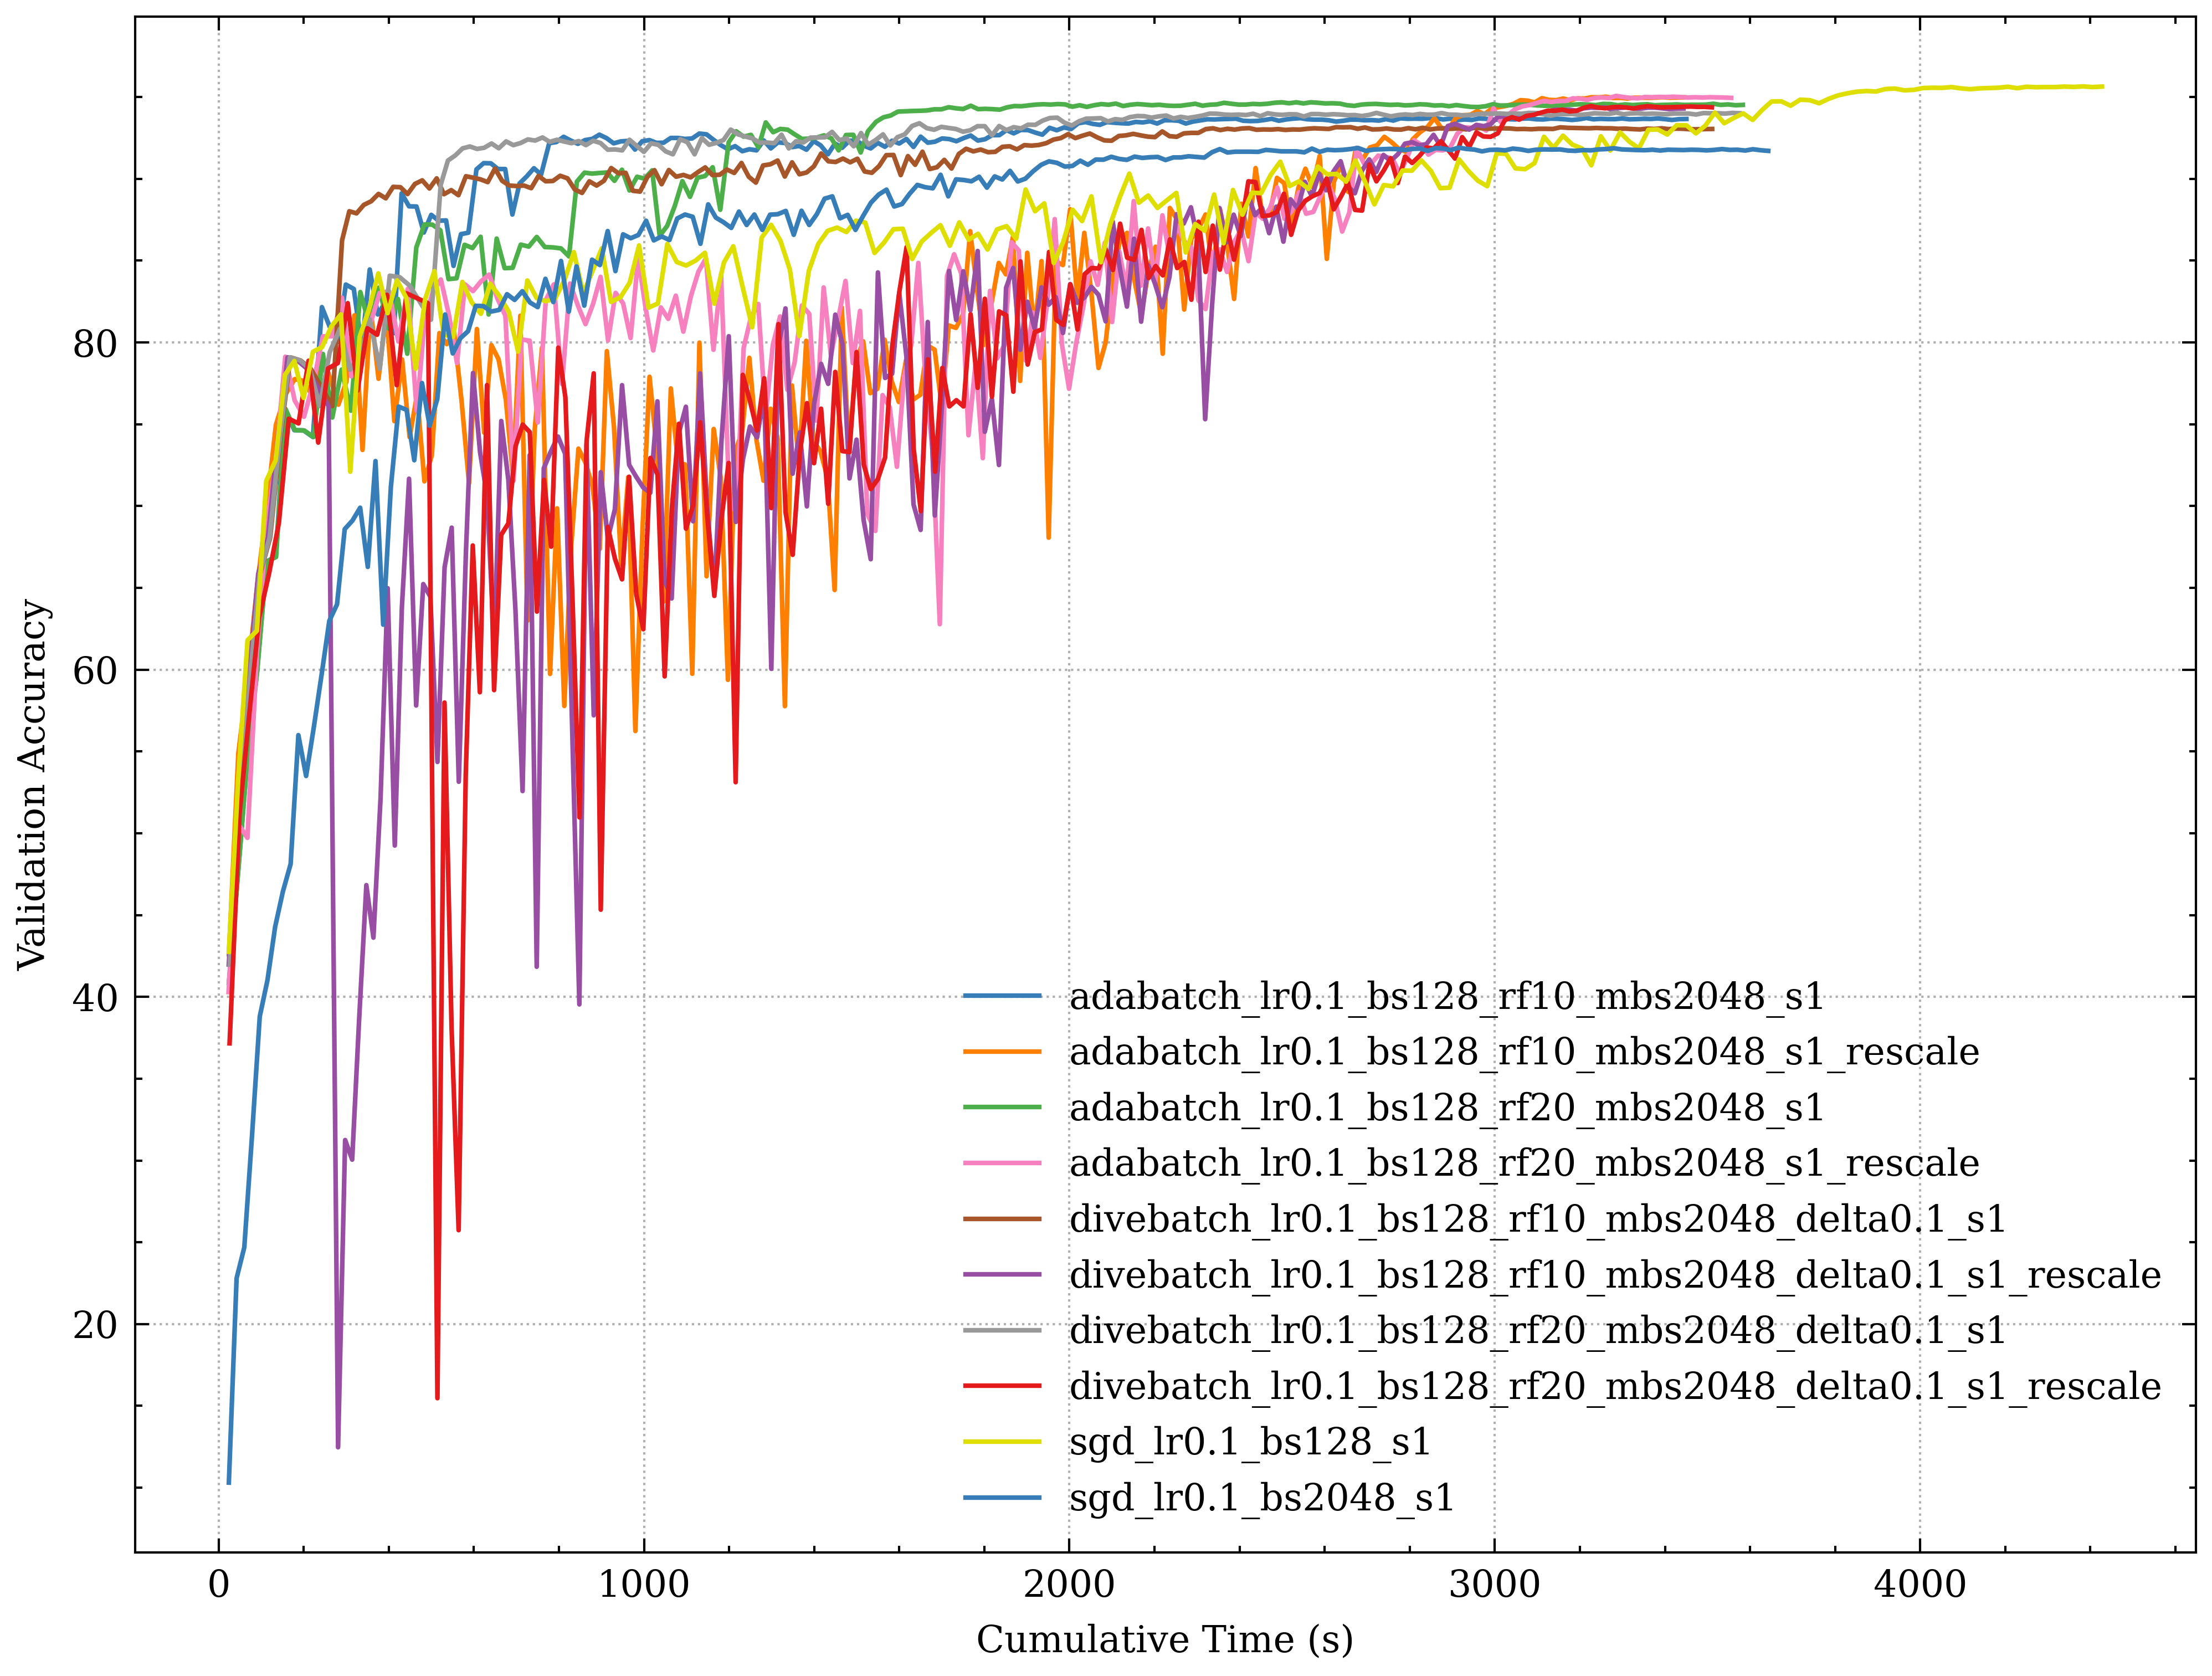

In [276]:
import matplotlib.pyplot as plt

def plot_cumulative_time_vs_accuracy(data, xlabel="Cumulative Time (s)", ylabel="Validation Accuracy", title="Cumulative Time vs. Validation Accuracy"):
    """
    Plots cumulative time (x-axis) vs. validation accuracy (y-axis) for multiple algorithms.

    Parameters:
    - data (dict): Dictionary where keys are algorithm names and values are DataFrames with 'abs_time' and 'val_acc_mean'.
    - xlabel (str): Label for the x-axis.
    - ylabel (str): Label for the y-axis.
    - title (str): Title of the plot.

    Returns:
    - None
    """
    plt.figure(figsize=(8, 6))
    for algorithm, df in data.items():
        plt.plot(df['abs_time'], df['val_acc'], label=algorithm)
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc="best")
    plt.grid(linestyle='dotted')
    plt.show()

# Example usage with your data
# Assuming `cifar10_data` is a dictionary where keys are algorithm names and values are DataFrames
plot_cumulative_time_vs_accuracy(cifar10_data)


In [277]:
def calculate_epochs_to_final(data, threshold=1.0):
    results = []
    for dataset, dataset_data in data.items():
        for algorithm, metrics in dataset_data.items():
            final_acc = metrics['val_acc_mean'][-1]
            threshold_acc = final_acc * (1 - threshold / 100)
            epoch_to_final = next(
                (epoch for epoch, acc in enumerate(metrics['val_acc_mean']) if acc >= threshold_acc),
                None
            )
            results.append({
                "Dataset": dataset,
                "Algorithm": algorithm,
                "Epoch to ±1%": epoch_to_final,
                "Final Accuracy": final_acc,
                "Total Epochs": len(metrics['val_acc_mean'])
            })
    return pd.DataFrame(results)
